# Detecting SPT by projective representation

We will try to detect SPT by projective representation. We will look at the phase diagram (studied by PhysRevB.86.125441) of a spin-1 chain that has the following Hamiltonian

$$H = J \sum_i \mathbf S_i \cdot \mathbf S_{i+1} + B \sum_i S^x_i + D \sum_i (S^z_i)^2$$
Without loss of generality we will set $J=1$ and measure everything in units of $J$

The phase diagram is known to take the following form:
<div>
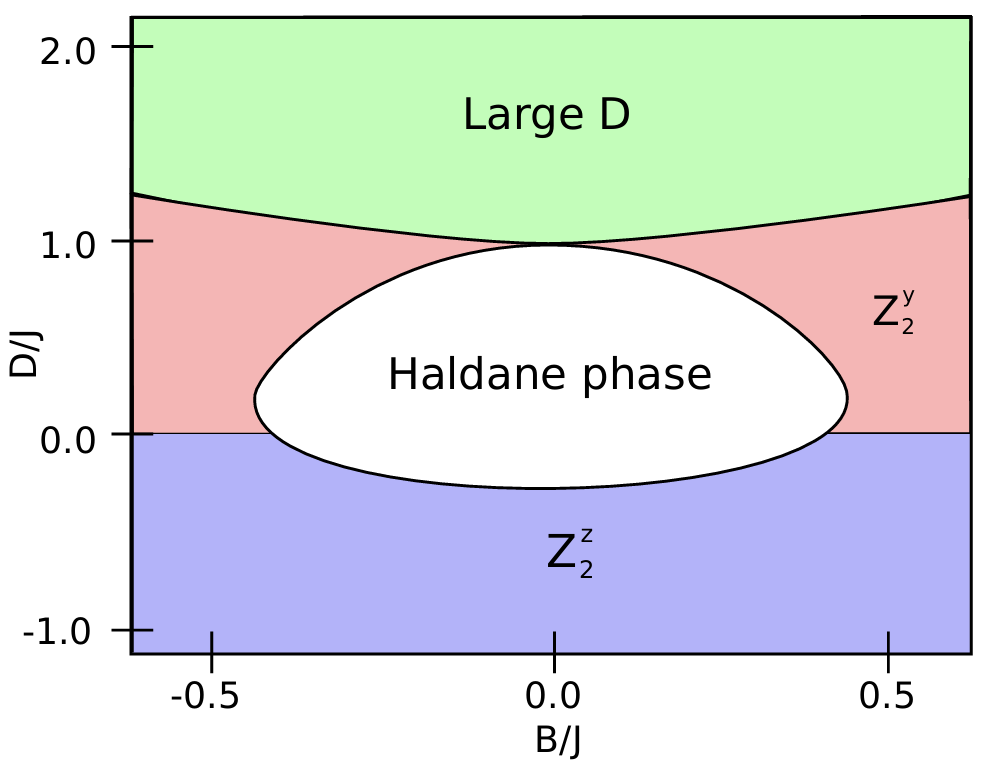
</div>
The Haldane phase is classified by the projective representation with -1 and that of large D is a trivial phase connected to $\ket{00000\cdots}$

In [1]:
from tenpy.networks.site import SpinSite
from tenpy.networks.mps import MPS
from tenpy.models.lattice import Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel
from tenpy.algorithms import dmrg
from tenpy.tools.params import asConfig
import tenpy.linalg.np_conserved as npc
import numpy as np

In [80]:
class SPTChain(MPOModel, CouplingModel,NearestNeighborModel):
    def __init__(self, model_params):
        model_params = asConfig(model_params, 'SPT Chain')
        L = model_params.get('L',2)
        B = model_params.get('B',0)
        D = model_params.get('D',0)
        self.B, self.D = B, D
        bc_MPS = model_params.get('bc_MPS','finite')
        sort_charge = model_params.get('sort_charge',True)

        conserve = 'Sz' if B == 0 else 'None' # Conserve Sz if no transverse field
        site = SpinSite(S=1,conserve=conserve,sort_charge=sort_charge)
        site.add_op('Sz2', npc.tensordot(site.Sz,site.Sz,('p*','p')))
                    
        bc = 'open' if bc_MPS == 'finite' else 'periodic'

        self.lat = Chain(L,site,bc=bc,bc_MPS=bc_MPS)

        CouplingModel.__init__(self,self.lat)
        self.add_coupling(0.5,0,'Sp',0,'Sm',1,plus_hc=True) # x-y part of the spin-spin interaction J=1
        self.add_coupling(1,0,'Sz',0,'Sz',1) # z part of the spin-spin interaction
        if B != 0:
            self.add_onsite(B,0,'Sx')
        self.add_onsite(D,0,'Sz2')

        MPOModel.__init__(self,self.lat,self.calc_H_MPO())
        NearestNeighborModel.__init__(self, self.lat, self.calc_H_bond()) 

## DMRG on infinite MPS
We will try to run DMRG on infinite MPS. The method is outlined in the documentation https://tenpy.readthedocs.io/en/latest/intro/overview.html#algorithms


The discussion about convergence is discussed below: https://tenpy.johannes-hauschild.de/viewtopic.php?t=28

Note that because the ground state is degenerate, in general it can be highly entangled.

For example, the Neel state $\frac{1}{\sqrt 2}\left(\ket{\uparrow\downarrow\uparrow} + \ket{\downarrow\uparrow\downarrow}\right)$ is maximally entangled. In fact, any linear combination will works. Therefore, DMRG will not converge nicely if you allow it to explore states of all entanglement. 

Therefore, if you set $\chi \gg 1$, the algorithm will return a warning where the MPS is not in canonical form. 

However, if you first limit the entanglement (i.e. $\chi \approx 1$), then the DMRG algorithm will converge to one of the spontaneously broken ground state. This will allow us to get a MPS

**Objection! The Haldane phase should respect symmetry of the system, it is not a SSB phase! So I should not get this problem! (Think about it tomorrow**

I observe that the infinite MPS DMRG results actually depends on the chain length $L$, why is it so?

In [81]:
L = 10
model = SPTChain(dict(L=L,B=0,D=10,bc_MPS='infinite'))
sites = model.lat.mps_sites()
psi = MPS.from_product_state(sites,['up' if i %2 == 0 else 'down' for i in range(L)],'infinite')
psi0 = MPS.from_product_state(sites,['up' if i %2 == 0 else 'down' for i in range(L)],'infinite')
dmrg_params = {'trunc_params':{'chi_max':50,'svd_min':1e-10},'mixer':True}
info = dmrg.run(psi,model,dmrg_params)

In [82]:
psi.compress_svd(dict(trunc_cut=1e-10))

TruncationError(eps=2.9995e-39, ov=1.0000000000)

In [83]:
psi.overlap(MPS.from_product_state(sites,[np.array([0,1,0])]*L,'infinite')) # Indeed we observe the |00000..> state 

/home/ymchan/miniconda3/envs/qinfo/lib/python3.8/site-packages/tenpy/networks/mps.py:3588: UserWarning: The returned overlap between two iMPS is **not** just <phi|psi>, as you might assume naively, but here defined to return the dominant eigenvalue eta of the (mixed) TransferMatrix. The former is lim_{N -> infty} eta^N and vanishes in the thermodynamic limit! See the warning in the docs of tenpy.networks.mps.
  warnings.warn("The returned overlap between two iMPS is **not** just <phi|psi>, "


(-0.9729583370828973+0j)

In [84]:
# let's get the infinite MPS transfer matrix
psi.get_B(3)

<npc.Array shape=(26, 3, 26) labels=['vL', 'p', 'vR']>

In [86]:
psi.get_SR(3) # Checking entanglement entropy 

array([1.60984860e-05, 3.88035905e-08, 1.23551783e-10, 5.24033570e-02,
       1.40663559e-04, 3.80549811e-07, 2.55286712e-08, 1.02319806e-09,
       2.39624046e-10, 9.97250074e-01, 1.60686903e-04, 7.92507832e-06,
       1.43023808e-07, 3.77943194e-08, 1.00745879e-08, 2.50723417e-10,
       1.15283999e-10, 5.24033570e-02, 1.40663559e-04, 3.80549811e-07,
       2.55286712e-08, 1.02319806e-09, 2.39624046e-10, 1.60984860e-05,
       3.88035905e-08, 1.23551783e-10])

In [93]:
B = psi.get_B(0).copy().drop_charge()

In [94]:
B, B.conj()

(<npc.Array shape=(26, 3, 26) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(26, 3, 26) labels=['vL*', 'p*', 'vR*']>)

## Transfer matrix computation
Consider a tensor block $A_{\alpha, \beta}^{i}$, the transfer matrix is the vectorized version of the operator $\sum_i A_i (\cdot) A_i^\dagger$, which has the form $\sum_i A_i\otimes \bar A_i$ in the vectorized notation. In index notation this becomes $$T_{\alpha \alpha'; \beta \beta'}= \sum_{i} A^i_{\alpha \beta} \bar A^i_{\alpha' \beta'}$$

In [95]:
T = npc.tensordot(B,B.conj(),('p','p*')).transpose(('vL','vL*','vR','vR*'))
T

<npc.Array shape=(26, 26, 26, 26) labels=['vL', 'vL*', 'vR', 'vR*']>

In [96]:
np.sort(np.abs(npc.eigvals(T.combine_legs((('vL','vL*'),('vR','vR*'))))))[:-10:-1] # The eigenvalues

array([1.        , 0.19656268, 0.19656268, 0.17882172, 0.17882172,
       0.1516895 , 0.1516895 , 0.11844775, 0.11844775])

## Checking $Z_2\times Z_2$ symmetry
The $Z_2\times Z_2$ symmetry is generated by the matrix $\exp(i\pi S^x)$ and $\exp(i\pi S^z)$

**Question:** I am quite confused now, say I have non zero $B$, then there is explicit symmetry breaking, how on earth are we still inside the Haldane phase? 

In [97]:
site = SpinSite(S=1,conserve='None')
Sz, Sx = site.Sz, site.Sx
Ux = npc.expm(1.j*np.pi*Sx)
Uz = npc.expm(1.j*np.pi*Sz)

In [98]:
Tux = npc.tensordot(npc.tensordot(B,Ux,('p','p')),B.conj(),('p*','p*')).transpose(('vL','vL*','vR','vR*'))
Tuz = npc.tensordot(npc.tensordot(B,Uz,('p','p')),B.conj(),('p*','p*')).transpose(('vL','vL*','vR','vR*'))

In [99]:
print(np.sort(np.abs(npc.eigvals(Tux.combine_legs((('vL','vL*'),('vR','vR*'))))))[:-10:-1]) # The eigenvalues
print(np.sort(np.abs(npc.eigvals(Tuz.combine_legs((('vL','vL*'),('vR','vR*'))))))[:-10:-1]) # The eigenvalues

[1.         0.19656268 0.19656268 0.17882172 0.17882172 0.1516895
 0.1516895  0.11844775 0.11844775]
[1.         0.19656268 0.19656268 0.17882172 0.17882172 0.1516895
 0.1516895  0.11844775 0.11844775]


As one can see, the dominant eigenvalue is exactly one

## Leg labeling with conjugate transpose
Consider the matrix $V$ which has leg label $(\alpha,\beta^*)$, multiplying by it's conjugate transpose gives
$$(VV^\dagger)_{\alpha\beta} = V_{\alpha\gamma} V^*_{\beta\gamma}$$
Now, the leg labeling of $V^*$ is $(\alpha^*,\beta)$. Therefore, the maneuver about translates to `npc.tensordot(V,V.conj(), ('b*', 'b'))`, which gives a tensor with leg indicies `(a,a*)`

On the other hand, for $V^\dagger V$, we need to contract the first index
$$(V^\dagger V)_{\alpha\beta} = V_{\gamma\alpha}^* V_{\gamma\beta}$$
So in terms of leg indices we have `npc.tensordot(V.conj(),V, ('a*', 'a'))` which gives a tensor with leg indicies `(b,b*)`

Conclusion, if you contracted correctly, the final indices must be of the order `(p,p*)`

## Normalization of the $V$ matrices
Consider the superoperator $\mathcal E_u(X) = \sum_{i} e^{i\theta_i}\tilde A_i X \tilde A_i^\dagger$, it has been shown that if $u$ is a symmetry of the channel, then the eigenvector of this operator can be made unitary, i.e. $V^\dagger V = \lambda I$ for some $\lambda$. Usually, $V$ is obtained numerically by diagonalizing the vectorized version of $\mathcal E_u$, which automatically normalize the trace norm of $V$ to 1, i.e. $\text{Tr}(V^\dagger V)=1$. Therefore, if we don't renormalize our matrices $V$, we will actually have $V^\dagger V = \chi^{-1} I$ where $\chi$ is the bond dimension

In [100]:
# Computation of the projective representation
eigval, eigvec = npc.eig(Tux.combine_legs((('vL','vL*'),('vR','vR*'))))

In [101]:
Vx = eigvec[:,0].copy().split_legs() # The leg labels are (vL.vL*), eig

In [102]:
# Computation of the projective representation
eigval, eigvec = npc.eig(Tuz.combine_legs((('vL','vL*'),('vR','vR*'))))

In [103]:
Vz = eigvec[:,0].copy().split_legs() # The leg labels are (vL.vL*), eig

In [104]:
# Checking that Vx Vx^dagger propto I
mat = npc.tensordot(Vx,Vx.conj(),('vL*','vL'))
np.abs(mat.to_ndarray())[:5,:5]*Vx.shape[0] # We need to multiply by the bond dimension to get the correct normalization

array([[1.00000000e+00, 6.78327429e-12, 8.65871985e-13, 1.67659169e-16,
        3.16451598e-16],
       [6.78327429e-12, 1.00000000e+00, 7.49564542e-13, 1.51723483e-16,
        3.05286916e-18],
       [8.65871985e-13, 7.49564542e-13, 1.00000000e+00, 5.19009277e-16,
        4.92294521e-17],
       [1.67659169e-16, 1.51723483e-16, 5.19009277e-16, 1.00000000e+00,
        2.83401260e-15],
       [3.16451598e-16, 3.05286916e-18, 4.92294521e-17, 2.83401260e-15,
        1.00000000e+00]])

In [105]:
VxVzVxdVzd = npc.tensordot(npc.tensordot(npc.tensordot(Vx,Vz,('vL*','vL')),Vx.conj(),('vL*','vL')),Vz.conj(),('vL*','vL'))

In [106]:
np.abs(npc.trace(VxVzVxdVzd))*Vx.shape[0] # As expected from the large D phase 

1.0

## Doing the same for the Haldane phase
The infinite one takes long to converge, so we will use a finite chain with 20 lattice site, open boundary conditions

In [181]:
L = 20
model = SPTChain(dict(L=L,B=0,D=0,bc_MPS='finite'))
sites = model.lat.mps_sites()
psi_cm = MPS.from_product_state(sites,['up' if i %2 == 0 else 'down' for i in range(L)],'finite')
psi0_cm = MPS.from_product_state(sites,['up' if i %2 == 0 else 'down' for i in range(L)],'finite')
dmrg_params = {'trunc_params':{'chi_max':140,'svd_min':1e-10},'mixer':True}
info = dmrg.run(psi_cm,model,dmrg_params)

In [203]:
info['E'], psi_cache_cm.overlap(psi_cache)

(-26.839978648482663, -0.9999998766786505)

In [195]:
psi_cm.get_SR(3)
psi_cache_cm = psi_cm.copy()
psi_cache_cm.compress_svd(dict(trunc_cut=1e-4,chi_max=67))
psi_cache_cm.get_SR(10).shape

(67,)

In [200]:
psi_cache_cm.get_B(L//2-2)

<npc.Array shape=(67, 3, 67) labels=['vL', 'p', 'vR']>

In [201]:
def detect_Z2xZ2(B):
    B = B.copy().drop_charge()
    _Tux = npc.tensordot(npc.tensordot(B,Ux,('p','p')),B.conj(),('p*','p*')).transpose(('vL','vL*','vR','vR*'))
    _Tuz = npc.tensordot(npc.tensordot(B,Uz,('p','p')),B.conj(),('p*','p*')).transpose(('vL','vL*','vR','vR*'))
    # Computation of the projective representation
    eigval, eigvec = npc.eig(_Tux.combine_legs((('vL','vL*'),('vR','vR*'))))
    max_idc = np.argmax(np.abs(eigval))
    _Vx = eigvec[:,max_idc].copy().split_legs() # The leg labels are (vL.vL*), eig
    print('Vx eigenvalue: ', eigval[max_idc])
    print('Vx matrix: ',  np.real(_Vx.to_ndarray()))
    # Computation of the projective representation
    eigval, eigvec = npc.eig(_Tuz.combine_legs((('vL','vL*'),('vR','vR*'))))
    max_idc = np.argmax(np.abs(eigval))
    _Vz = eigvec[:,max_idc].copy().split_legs() # The leg labels are (vL.vL*), eig
    print('Vz eigenvalue: ', eigval[max_idc])
    print('Vz matrix: ',  np.real(_Vz.to_ndarray()))
    #print(npc.tensordot(_Vx,_Vz,('vL*','vL')).to_ndarray())
    #print(npc.tensordot(npc.tensordot(_Vx,_Vz,('vL*','vL')),_Vx.conj(),('vL*','vL')).to_ndarray())
    _VxVzVxdVzd = npc.tensordot(npc.tensordot(npc.tensordot(_Vx,_Vz,('vL*','vL')),_Vx.conj(),('vL*','vL')),_Vz.conj(),('vL*','vL'))
    return npc.trace(_VxVzVxdVzd)*_Vx.shape[0]

In [204]:
detect_Z2xZ2(psi_cache.get_B(L//2-2))

Vx eigenvalue:  (0.9579050049970674-2.168404344971009e-19j)
Vx matrix:  [[ 1.18780132e-18 -1.26071817e-17 -2.26889031e-17 ...  1.60161693e-16
  -4.44911204e-19 -8.34052019e-19]
 [ 1.13203181e-17 -1.14842204e-18  1.56200046e-16 ... -3.01875538e-16
  -3.40536661e-19 -6.38157858e-19]
 [ 1.35250559e-18 -9.19380307e-17  5.50036805e-19 ... -3.73191252e-19
   5.42146291e-02  4.83330611e-02]
 ...
 [ 9.58088834e-17 -4.13168807e-16  6.75708952e-20 ...  7.72914485e-38
   8.97390687e-34  1.81864491e-34]
 [-6.89062034e-19 -1.44972932e-18  5.42146291e-02 ...  8.97390687e-34
   2.67107050e-53 -1.36498900e-53]
 [-9.33965901e-19 -2.98005303e-19  4.83330611e-02 ...  1.81864491e-34
  -1.36471299e-53  3.26155531e-54]]
Vz eigenvalue:  (0.9999999999999998-5.768757591944815e-19j)
Vz matrix:  [[ 1.22169444e-01 -3.22384501e-16  4.08220246e-17 ... -6.78849248e-53
  -1.17989353e-57  1.23357810e-58]
 [-5.69523564e-16  1.22169444e-01  6.29725644e-19 ...  1.86322689e-52
   6.64279691e-61 -4.07441349e-59]
 [-0.00000

(-1.0000000000000029+1.8065222878352272e-31j)

The confusing part is if I have two wavefunction, which has 0.9999 overlap, and do such a calculation, I can get -1 or 1, so I don't think the algorithm here is numerically stable. Maybe a better way will be to renormalize the wavefunction a bit

In [113]:
psi.overlap(psi1)

1.0000000000000087

In [267]:
exp_string_op(psi,20) # It seems like thet string order parameter is not vanishing, so we are actually good

array([[1.08757642e-02, 5.38611652e-03, 5.61448194e-05, 2.60664973e-06,
        7.34600519e-08, 2.78808667e-09, 9.89609194e-11, 3.73308559e-12,
        1.40364689e-13, 5.35977840e-15, 2.05437765e-16, 7.91891245e-18,
        3.06187323e-19, 1.18718000e-20, 4.61208039e-22, 1.79466196e-23,
        6.99920546e-25, 2.80577123e-26, 1.86815501e-27, 8.44368082e-28]])

In [121]:
exp_string_op(psi1,20) # It seems like thet string order parameter is not vanishing, so we are actually good

array([[0.66666667, 0.53765477, 0.39861295, 0.37288592, 0.3508138 ,
        0.3420019 , 0.33498281, 0.33138961, 0.32856846, 0.32693136,
        0.32561006, 0.32477523, 0.32405335, 0.32355872, 0.32307785,
        0.32271485, 0.32229804, 0.32194557, 0.32145557, 0.32099839]])

In [87]:
psi.entanglement_entropy(2)

array([1.09861225, 0.82148383, 1.19754193, 1.13348523, 1.28993797,
       1.28226015, 1.35238455, 1.3562881 , 1.38955317, 1.39325962,
       1.40984262, 1.41111838, 1.41964118, 1.41834981, 1.42253247,
       1.41834981, 1.41964118, 1.41111838, 1.40984262, 1.39325962,
       1.38955317, 1.3562881 , 1.35238455, 1.28226015, 1.28993797,
       1.13348522, 1.19754193, 0.82148383, 1.09861225])

In [88]:
psi.get_SR(10)

array([5.18506709e-01, 5.18427122e-01, 5.18347449e-01, 4.06781204e-01,
       6.01106407e-02, 6.01061542e-02, 6.01016569e-02, 5.76656083e-02,
       5.76610853e-02, 5.76565810e-02, 5.76520943e-02, 5.76476271e-02,
       1.27983668e-02, 1.27963910e-02, 1.27943879e-02, 1.25342972e-02,
       3.60360038e-03, 3.60332297e-03, 3.60305017e-03, 3.52581192e-03,
       3.52553854e-03, 3.52526050e-03, 3.52500047e-03, 3.52472857e-03,
       1.08727053e-03, 1.08719966e-03, 1.08711036e-03, 1.08704092e-03,
       1.08695545e-03, 9.83663218e-04, 9.83627319e-04, 9.83582134e-04,
       9.83532945e-04, 9.83481742e-04, 9.83430524e-04, 9.83380283e-04,
       8.70250564e-04, 8.70213914e-04, 8.70126769e-04, 8.25571319e-04,
       8.25531640e-04, 8.25491176e-04, 8.25451682e-04, 8.25411387e-04,
       5.74374365e-04, 5.74296868e-04, 5.74216448e-04, 4.91732387e-04,
       2.28491149e-04, 2.16071784e-04, 2.16031777e-04, 2.16000109e-04,
       1.44265031e-04, 1.44253134e-04, 1.44240084e-04, 1.44187480e-04,
      

In [268]:
psi_cache = psi.copy()
psi_cache.compress_svd(dict(trunc_cut=1e-3))

TruncationError(eps=1.9658e-06, ov=0.9999960684)

In [269]:
psi_cache.get_SR(16)

array([0.05240304, 0.99725014, 0.05240304])

In [263]:
detect_Z2xZ2(psi_cache.get_B(L//2))

Vx eigenvalue:  (-0.9999999999999998+2.840926603080982e-18j)
Vx matrix:  [[ 4.39542124e-33 -1.37159563e-17 -5.77350269e-01]
 [-5.46374797e-18  5.77350269e-01  1.60112242e-33]
 [-5.77350269e-01 -1.64026770e-34 -6.40987562e-17]]
Vz eigenvalue:  (1.0000000000000009+0j)
Vz matrix:  [[ 0.57735027 -0.         -0.        ]
 [-0.         -0.57735027 -0.        ]
 [-0.         -0.          0.57735027]]


(0.9999999999999998+1.0168910106364605e-31j)

In [147]:
#psi.compress_svd(dict(trunc_cut=5e-5))
B = psi_cache.get_B(L//2).drop_charge()
Tux = npc.tensordot(npc.tensordot(B,Ux,('p','p')),B.conj(),('p*','p*')).transpose(('vL','vL*','vR','vR*'))
Tuz = npc.tensordot(npc.tensordot(B,Uz,('p','p')),B.conj(),('p*','p*')).transpose(('vL','vL*','vR','vR*'))

In [148]:
psi_cache.get_B(16)

<npc.Array shape=(47, 3, 47) labels=['vL', 'p', 'vR']>

In [149]:
# The symmetry is not ok

In [150]:
print(np.sort(np.abs(npc.eigvals(Tux.combine_legs((('vL','vL*'),('vR','vR*'))))))[:-10:-1]) # The eigenvalues
print(np.sort(np.abs(npc.eigvals(Tuz.combine_legs((('vL','vL*'),('vR','vR*'))))))[:-10:-1]) # The eigenvalues

[0.99971967 0.97251477 0.97198735 0.97051677 0.66392895 0.65259336
 0.61233415 0.60208282 0.57143703]
[1.         0.97224407 0.97224407 0.97053956 0.65830382 0.65830382
 0.6092286  0.6092286  0.55156885]


In [151]:
# Computation of the projective representation
eigval, eigvec = npc.eig(Tux.combine_legs((('vL','vL*'),('vR','vR*'))))
Vx = eigvec[:,0].copy().split_legs() # The leg labels are (vL.vL*), eig
# Computation of the projective representation
eigval, eigvec = npc.eig(Tuz.combine_legs((('vL','vL*'),('vR','vR*'))))
Vz = eigvec[:,0].copy().split_legs() # The leg labels are (vL.vL*), eig

In [152]:
eigvec[:,0], eigval[0]

(<npc.Array shape=(2209,) labels=['(vL.vL*)']>,
 (1.0000000000000013+3.51578395550761e-18j))

In [251]:
detect_Z2xZ2(psi_cache.get_B(16))

Vx eigenvalue:  (-0.986830795500082-5.052218843181e-19j)
Vz eigenvalue:  (1.0000000000000036+2.2738450576531433e-18j)


(1.0000000000000022+3.8696747407600536e-30j)

In [27]:
def detect_Z2xZ2(B):
    B = B.copy().drop_charge()
    _Tux = npc.tensordot(npc.tensordot(B,Ux,('p','p')),B.conj(),('p*','p*')).transpose(('vL','vL*','vR','vR*'))
    _Tuz = npc.tensordot(npc.tensordot(B,Uz,('p','p')),B.conj(),('p*','p*')).transpose(('vL','vL*','vR','vR*'))
    # Computation of the projective representation
    eigval, eigvec = npc.eig(_Tux.combine_legs((('vL','vL*'),('vR','vR*'))))
    max_idc = np.argmax(np.abs(eigval))
    _Vx = eigvec[:,max_idc].copy().split_legs() # The leg labels are (vL.vL*), eig
    print('Vx eigenvalue: ', eigval[max_idc])
    print('Vx matrix: ',  np.real(_Vx.to_ndarray()))
    # Computation of the projective representation
    eigval, eigvec = npc.eig(_Tuz.combine_legs((('vL','vL*'),('vR','vR*'))))
    max_idc = np.argmax(np.abs(eigval))
    _Vz = eigvec[:,max_idc].copy().split_legs() # The leg labels are (vL.vL*), eig
    print('Vz eigenvalue: ', eigval[max_idc])
    print('Vz matrix: ',  np.real(_Vz.to_ndarray()))
    #print(npc.tensordot(_Vx,_Vz,('vL*','vL')).to_ndarray())
    #print(npc.tensordot(npc.tensordot(_Vx,_Vz,('vL*','vL')),_Vx.conj(),('vL*','vL')).to_ndarray())
    _VxVzVxdVzd = npc.tensordot(npc.tensordot(npc.tensordot(_Vx,_Vz,('vL*','vL')),_Vx.conj(),('vL*','vL')),_Vz.conj(),('vL*','vL'))
    return npc.trace(_VxVzVxdVzd)*_Vx.shape[0]

In [4]:
from tenpy.networks.site import SpinSite, kron

In [169]:
class myaklt(NearestNeighborModel, MPOModel):

    def __init__(self, model_params):
        model_params = asConfig(model_params, "AKLTModel")
        L = model_params.get('L', 2)
        site = SpinSite(S=1., conserve='Sz')

        # lattice
        bc_MPS = model_params.get('bc_MPS', 'finite')
        bc = 'open' if bc_MPS == 'finite' else 'periodic'
        lat = Chain(L, site, bc=bc, bc_MPS=bc_MPS)

        Sp, Sm, Sz = site.Sp, site.Sm, site.Sz
        S_dot_S = 0.5 * (kron(Sp, Sm) + kron(Sm, Sp)) + kron(Sz, Sz)
        #S_dot_S_square = npc.tensordot(S_dot_S, S_dot_S, [['(p0*.p1*)'], ['(p0.p1)']])

        H_bond = S_dot_S #+ S_dot_S_square / 3.
        # P_2 = H_bond * 0.5 + 1/3 * npc.eye_like(S_dot_S)

        J = model_params.get('J', 1.)
        H_bond = J * H_bond.split_legs().transpose(['p0', 'p1', 'p0*', 'p1*'])
        H_bond = [H_bond] * L
        # H_bond[i] acts on sites (i-1, i)
        if bc_MPS == "finite":
            H_bond[0] = None
        # 7) initialize H_bond (the order of 7/8 doesn't matter)
        NearestNeighborModel.__init__(self, lat, H_bond)
        # 9) initialize H_MPO
        MPOModel.__init__(self, lat, self.calc_H_MPO_from_bond())


In [172]:
L= 20
haldaneModel = myaklt(dict(L=L,bc_MPS='finite'))
sites = [SpinSite(S=1)]*L
psi = MPS.from_product_state(sites,['up' if i %2 == 0 else 'down' for i in range(L)])
psi0 = MPS.from_product_state(sites,['up' if i %2 == 0 else 'down' for i in range(L)])
dmrg_params = {'trunc_params':{'chi_max':100,'svd_min':1e-10},'mixer':True}
info = dmrg.run(psi,haldaneModel,dmrg_params)

In [173]:
info['E']

-26.83997863242449

In [174]:
psi0.overlap(psi)

0.05957985366275616

In [175]:
psi_cache = psi.copy()
psi_cache.canonical_form()
#psi_cache.enlarge_chi(70)
psi_cache.compress_svd(dict(trunc_cut=1e-4))

TruncationError(eps=1.1347e-07, ov=0.9999997731)

In [176]:
np.sort(psi_cache.get_SR(L//2))

array([3.73341646e-05, 3.73431888e-05, 3.73435661e-05, 3.73456961e-05,
       3.73607720e-05, 3.74040012e-05, 3.74040540e-05, 6.04047598e-05,
       6.04357711e-05, 6.04959972e-05, 9.19895894e-05, 9.20932827e-05,
       9.21455991e-05, 9.21857097e-05, 9.22164672e-05, 1.36291492e-04,
       1.47721256e-04, 1.47746588e-04, 1.47765425e-04, 2.98402096e-04,
       3.61603344e-04, 3.61724567e-04, 3.61766104e-04, 5.62182814e-04,
       5.62185767e-04, 5.62187301e-04, 5.62188548e-04, 5.62189797e-04,
       6.08764291e-04, 6.08781408e-04, 6.08811387e-04, 8.53979685e-04,
       8.53980379e-04, 8.53982244e-04, 8.53984224e-04, 8.53988854e-04,
       8.54013648e-04, 8.54013670e-04, 8.93691733e-04, 8.93712366e-04,
       8.93722059e-04, 8.93731086e-04, 8.93736525e-04, 2.82564740e-03,
       2.82564931e-03, 2.82566236e-03, 2.89811035e-03, 2.89812352e-03,
       2.89812971e-03, 2.89815837e-03, 2.89818862e-03, 9.73710562e-03,
       1.08134548e-02, 1.08134637e-02, 1.08134746e-02, 5.32167856e-02,
      

In [177]:
psi_cache.get_B(L//2-2)

<npc.Array shape=(67, 3, 67) labels=['vL', 'p', 'vR']>

In [178]:
detect_Z2xZ2(psi_cache.get_B(L//2-2))

Vx eigenvalue:  (0.9579050049970674-2.168404344971009e-19j)
Vx matrix:  [[ 1.18780132e-18 -1.26071817e-17 -2.26889031e-17 ...  1.60161693e-16
  -4.44911204e-19 -8.34052019e-19]
 [ 1.13203181e-17 -1.14842204e-18  1.56200046e-16 ... -3.01875538e-16
  -3.40536661e-19 -6.38157858e-19]
 [ 1.35250559e-18 -9.19380307e-17  5.50036805e-19 ... -3.73191252e-19
   5.42146291e-02  4.83330611e-02]
 ...
 [ 9.58088834e-17 -4.13168807e-16  6.75708952e-20 ...  7.72914485e-38
   8.97390687e-34  1.81864491e-34]
 [-6.89062034e-19 -1.44972932e-18  5.42146291e-02 ...  8.97390687e-34
   2.67107050e-53 -1.36498900e-53]
 [-9.33965901e-19 -2.98005303e-19  4.83330611e-02 ...  1.81864491e-34
  -1.36471299e-53  3.26155531e-54]]
Vz eigenvalue:  (0.9999999999999998-5.768757591944815e-19j)
Vz matrix:  [[ 1.22169444e-01 -3.22384501e-16  4.08220246e-17 ... -6.78849248e-53
  -1.17989353e-57  1.23357810e-58]
 [-5.69523564e-16  1.22169444e-01  6.29725644e-19 ...  1.86322689e-52
   6.64279691e-61 -4.07441349e-59]
 [-0.00000

(-1.0000000000000029+1.8065222878352272e-31j)

## String order parameter
The string order parameter of the same form of the AKLT state is still useful in detecting topological phases, so to compute that

In [179]:
def exp_string_op(state,sitelim):
    site = SpinSite(S=1,conserve='Sz')
    expSz = npc.expm(np.pi*1.j*site.Sz)
    return state.correlation_function('Sz','Sz',opstr=expSz,str_on_first=True,sites1=1,sites2=sitelim)

In [180]:
exp_string_op(psi_cache,20) # It seems like thet string order parameter is not vanishing, so we are actually good

array([[0.66666667, 0.53958903, 0.39775818, 0.37238552, 0.34853247,
        0.33947716, 0.33093659, 0.32682144, 0.32253593, 0.32020298,
        0.31724917, 0.31550559, 0.31254329, 0.31073475, 0.30629069,
        0.30388728, 0.29423442, 0.29155077, 0.26046658, 0.27187961]])

In [ ]:
exp_string_op(psi

In [254]:
exp_string_op(psi1,20) # It seems like thet string order parameter is not vanishing, so we are actually good

array([[0.66666667, 0.53765477, 0.39861295, 0.37288592, 0.3508138 ,
        0.3420019 , 0.33498281, 0.33138961, 0.32856846, 0.32693136,
        0.32561006, 0.32477523, 0.32405335, 0.32355872, 0.32307785,
        0.32271485, 0.32229804, 0.32194557, 0.32145557, 0.32099839]])

In [255]:
exp_string_op(MPS.from_product_state(sites,[np.array([0,1,0])]*L),10)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

1.0000000000000004

## Code above not working, need to study why
## Not to mention the phase is not respecting the symmetry up to machine precision, so things must have gone wrong

In [157]:
psi.get_SR(0)

array([0.69490432, 0.69490421, 0.10240275, 0.10240238, 0.07797534,
       0.07797459, 0.02063952, 0.02063336, 0.00856908, 0.00855446,
       0.00480143, 0.00479671, 0.00250919, 0.00250132, 0.00243497,
       0.00243471, 0.00223147, 0.0022211 , 0.00137892, 0.00137787,
       0.00091355])